In [230]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import time
import glob,os
import cv2
from scipy import optimize
from scipy import ndimage
from pylab import *
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import igor

## Load registered HAADF image and detected peak positions
Optimize.curve_fit is used instead of least square fit in order to implement boundaries for fitting.
<br>For some reason, I cannot generate an array for boundaries that satisfy the requirments in least square fit method.

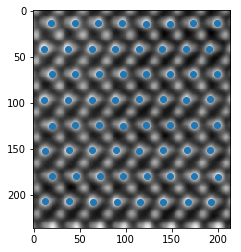

In [8]:
path = '/srv/home/chenyu/DEbackup/101618/101618_LaAuGe/Area2/S11/S11_HAADF_results.mat'
file = sio.loadmat(path)
peaks_x = file['x_loc']
peaks_y = file['y_loc']
image = np.transpose(file['HAADF'])
plt.imshow(image,cmap=plt.cm.gray)
plt.scatter(peaks_x,peaks_y)

In [396]:
def gaussianx2(xdata_tuple,bg,height_1, height_2, center_x_1, center_y_1, width_x_1, width_y_1,center_x_2, center_y_2, width_x_2, width_y_2):

    (x, y) = xdata_tuple
    width_x_1 = float(width_x_1)
    width_y_1 = float(width_y_1)
    width_x_2 = float(width_x_2)
    width_y_2 = float(width_y_2)
    g = height_1*exp(
                 -(((center_x_1-x)/width_x_1)**2+((center_y_1-y)/width_y_1)**2)/2)+height_2*exp(
                 -(((center_x_2-x)/width_x_2)**2+((center_y_2-y)/width_y_2)**2)/2)+bg
    return g.ravel()

def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, patch.shape[1]-1, patch.shape[1])
    y = np.linspace(0, patch.shape[0]-1, patch.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt



190 41
-336.8666760151373
(6700, 119.38627027212533, 892.2471897023506, 10, 10, 5, 5, 16, 10, 3, 3)
([0, 0, 0, 9, 9, 0, 0, 15, 9, 0, 0], [inf, inf, inf, 11, 11, inf, inf, 17, 11, inf, inf])


Text(0.5,1,'Fitted')

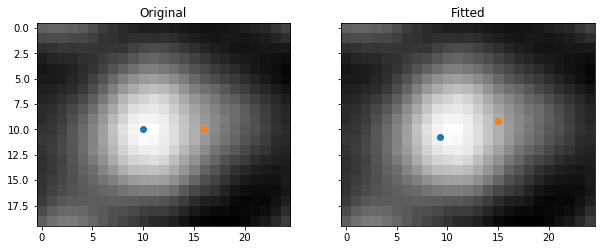

In [442]:
ipeak=13

x = int(peaks_x[ipeak])
y = int(peaks_y[ipeak])
print(x,y)
line = image[y,x-8:x+8]
maxpos = np.argmax(line)

# if diff<0, then Ge peak is on the right side of Au peak, and patch should be cropped toward positive x
diff = line[maxpos-6]-line[maxpos+6]
print(diff)
if diff>0:
    patch = image[y-10:y+10,x-15:x+10]
    x1 = 16
    y1 = 10
    x2 = 8
    y2 = 10
else:
    patch = image[y-10:y+10,x-10:x+15]
    x1 = 10
    y1 = 10
    x2 = 16
    y2 = 10



# prepare initial guess
bg = 6700   # hard coded background level, lowest intensity value in the image
width_x_1 = 5
width_y_1 = 5
width_x_2 = 3
width_y_2 = 3
height_1 = image[x,y]-bg
height_2 = image[x-7,y-2]-bg

# feed to fitGaussainx2 function
guess = (bg,height_1, height_2, x1, y1, width_x_1, width_y_1, x2, y2, width_x_2, width_y_2)
boundary = ([0,0,0,x1-1,y1-1,0,0,x2-1,y2-1,0,0],[np.inf,np.inf,np.inf,x1+1,y1+1,np.inf,np.inf,x2+1,y2+1,np.inf,np.inf])
print(guess)
print(boundary)
# boundary = (-np.inf,np.inf)
popt = fitGaussianx2(patch, guess, boundary)


fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(patch, cmap=plt.cm.gray)
ax[0].scatter(guess[3],guess[4])
ax[0].scatter(guess[7],guess[8])
ax[0].set_title('Original')

ax[1].imshow(patch, cmap=plt.cm.gray)
ax[1].scatter(popt[3],popt[4])
ax[1].scatter(popt[7],popt[8])
ax[1].set_title('Fitted')


In [443]:
    if diff>0:
        Au_x_list[ipeak] = popt[3]+x-15
        Au_y_list[ipeak] = popt[4]+y-10
        Ge_x_list[ipeak] = popt[7]+x-15
        Ge_y_list[ipeak] = popt[8]+y-10
    else:
        Au_x_list[ipeak] = popt[3]+x-10
        Au_y_list[ipeak] = popt[4]+y-10
        Ge_x_list[ipeak] = popt[7]+x-10
        Ge_y_list[ipeak] = popt[8]+y-10

In [430]:
Au_x_list = []
Au_y_list = []
Ge_x_list = []
Ge_y_list = []
avoid_list = []

for ipeak in range(len(peaks_x)):
    if ipeak in avoid_list:
        continue
    # extract patch from whole image
    x = int(peaks_x[ipeak])
    y = int(peaks_y[ipeak])
#     print(x,y)
    line = image[y,x-8:x+8]
    maxpos = np.argmax(line)
    # if diff<0, then Ge peak is on the right side of Au peak, and patch should be cropped toward positive x
    diff = line[maxpos-6]-line[maxpos+6]
#     print(diff)
    if diff>0:
        patch = image[y-10:y+10,x-15:x+10]
        x1 = 16
        y1 = 10
        x2 = 8
        y2 = 10
    else:
        patch = image[y-10:y+10,x-10:x+15]
        x1 = 10
        y1 = 10
        x2 = 16
        y2 = 10



    # prepare initial guess
    bg = 6700   # hard coded background level, lowest intensity value in the image
    width_x_1 = 5
    width_y_1 = 5
    width_x_2 = 3
    width_y_2 = 3
    height_1 = image[x,y]-bg
    height_2 = image[x-7,y-2]-bg

    # feed to fitGaussainx2 function
    guess = (bg,height_1, height_2, x1, y1, width_x_1, width_y_1, x2, y2, width_x_2, width_y_2)
    boundary = ([0,0,0,x1-3,y1-3,0,0,x2-3,y2-3,0,0],[np.inf,np.inf,np.inf,x1+3,y1+3,np.inf,np.inf,x2+3,y2+3,np.inf,np.inf])
    popt = fitGaussianx2(patch, guess, boundary)
    
    if diff>0:
        Au_x_list.append(popt[3]+x-15)
        Au_y_list.append(popt[4]+y-10)
        Ge_x_list.append(popt[7]+x-15)
        Ge_y_list.append(popt[8]+y-10)
    else:
        Au_x_list.append(popt[3]+x-10)
        Au_y_list.append(popt[4]+y-10)
        Ge_x_list.append(popt[7]+x-10)
        Ge_y_list.append(popt[8]+y-10)





Text(0.5,1,'Fitted')

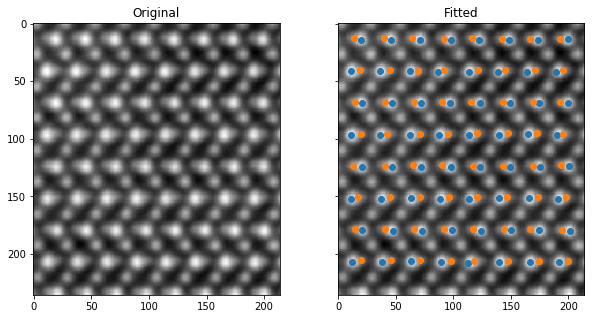

In [444]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].scatter(Au_x_list,Au_y_list)
ax[1].scatter(Ge_x_list,Ge_y_list)
ax[1].set_title('Fitted')

In [445]:
x_array = np.asarray(Au_x_list+Ge_x_list)
y_array = np.asarray(Au_y_list+Ge_y_list)
np.save('/srv/home/chenyu/DEbackup/101618/101618_LaAuGe/Area2/S11/peaks_x.npy',x_array)
np.save('/srv/home/chenyu/DEbackup/101618/101618_LaAuGe/Area2/S11/peaks_y.npy',y_array)

In [435]:
print(peaks_x[31],peaks_y[31])

[37.] [97.]
